In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import tams

import seaborn as sns
import ptitprince as pt
import pandas as pd

## Load data

In [2]:
data = tams.load_example_mpas()
tb = data.tb.isel(time=slice(2,None))

## Identify cloud elements (CEs)

In [3]:
times_ = tb.time.values
# contour_sets = [tams.identify(tb.sel(time=time)) for time in times]
contour_sets = []
times = []
for time in times_:
    try:
        cs = tams.identify(tb.sel(time=time))
    except Exception as e:
        print("Error", time, e)
    else:
        contour_sets.append(cs)
        times.append(time)

46.9%  of 235s are big enough
32.0% of big-enough 235s have enough 219 area
38.0%  of 235s are big enough
54.4% of big-enough 235s have enough 219 area
34.3%  of 235s are big enough
45.8% of big-enough 235s have enough 219 area
34.4%  of 235s are big enough
38.1% of big-enough 235s have enough 219 area
32.0%  of 235s are big enough
47.7% of big-enough 235s have enough 219 area
35.5%  of 235s are big enough
38.5% of big-enough 235s have enough 219 area
32.6%  of 235s are big enough
43.7% of big-enough 235s have enough 219 area
30.9%  of 235s are big enough
41.8% of big-enough 235s have enough 219 area
30.4%  of 235s are big enough
32.4% of big-enough 235s have enough 219 area
27.5%  of 235s are big enough
34.8% of big-enough 235s have enough 219 area
28.6%  of 235s are big enough
33.8% of big-enough 235s have enough 219 area
25.1%  of 235s are big enough
26.2% of big-enough 235s have enough 219 area
29.1%  of 235s are big enough
22.7% of big-enough 235s have enough 219 area
24.6%  of 23

## Track CE groups between times

In [4]:
cs = tams.track(contour_sets, times, u_projection=-5)

/glade/u/home/knocasio/git/TAMS/tams.py:402: UserWarning: unequal time spacing
  warnings.warn("unequal time spacing")


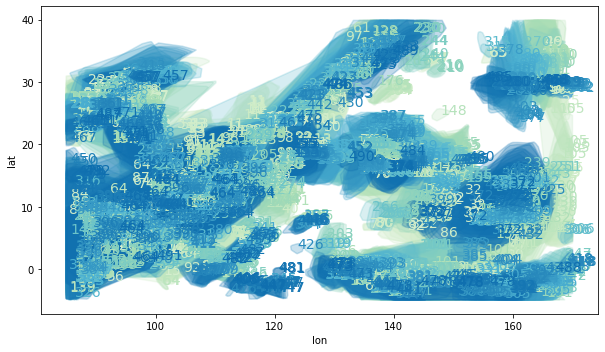

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.set(xlabel="lon", ylabel="lat")

colors = plt.cm.GnBu(np.linspace(0.2, 0.85, len(times)))

# Plot blobs at each time
for i, g in cs.groupby("itime"):
    color = colors[i]

    g.plot(ax=ax, facecolor=color, edgecolor=color, alpha=0.25, lw=1.5)

    # Label blobs with assigned ID
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.",
        )
        for id_, x, y in zip(g.id, g.centroid.x, g.centroid.y):
            ax.text(x, y, id_, c=color, fontsize=14, zorder=10)


fig.tight_layout()

## Classify

In [6]:
classes = cs.groupby("id").apply(tams.classify)
cs["class"] = cs.id.map(classes)

### Define a variable that groups by id the classes to plot by number of MCSs

In [7]:
c = pd.DataFrame({"class": classes})

In [39]:
c

,class,duration
id,,
0,DSL,1
1,DSL,1
2,DSL,1
3,DSL,1
4,DSL,1
...,...,...
488,DSL,1
489,DSL,1
490,DSL,1


## Assign rainfall

In [8]:
from tqdm import tqdm

In [9]:
rains = []
for i, g in tqdm(cs.groupby("itime")):
    rain = tams.data_in_contours(data=data.precip.isel(time=i), contours=g, merge=True, method="regionmask")
    rains.append(rain)
    
rain = pd.concat(rains)

100%|██████████| 116/116 [00:17<00:00,  6.65it/s]


,geometry,area_km2,area219_km2,time,itime,duration,id,class,mean_precip,std_precip,count_precip
10,"POLYGON ((166.75000 6.73783, 169.25000 7.58141...",1.633659e+05,119486.430461,2006-09-08 14:00:00,0,0 days 01:00:00,0,DSL,<NA>,<NA>,0
21,"POLYGON ((166.75000 27.70158, 167.00000 27.767...",1.711903e+04,5579.372522,2006-09-08 14:00:00,0,0 days 01:00:00,1,DSL,<NA>,<NA>,0
23,"POLYGON ((164.00000 30.89926, 166.00000 32.940...",1.208633e+05,12406.045230,2006-09-08 14:00:00,0,0 days 01:00:00,2,DSL,<NA>,<NA>,0
3,"POLYGON ((156.25000 -0.31079, 157.00000 0.0812...",1.954487e+04,11009.523649,2006-09-08 14:00:00,0,0 days 01:00:00,3,DSL,<NA>,<NA>,0
9,"POLYGON ((155.50000 6.46732, 156.29934 8.12500...",4.361601e+05,299378.907537,2006-09-08 14:00:00,0,0 days 01:00:00,4,DSL,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...
10,"POLYGON ((93.75000 -0.27679, 95.50000 -0.19343...",1.840895e+05,51230.995770,2006-09-13 18:00:00,115,0 days 01:00:00,464,CCC,0.451252,0.680883,239
18,"POLYGON ((96.00000 17.66851, 97.00000 18.08830...",4.371303e+05,177435.774722,2006-09-13 18:00:00,115,0 days 01:00:00,471,CCC,0.477453,0.447334,567
1,"POLYGON ((88.75000 -0.76241, 89.00000 -0.69936...",2.361151e+06,784764.046105,2006-09-13 18:00:00,115,0 days 01:00:00,464,CCC,0.697516,0.811967,2924
19,"POLYGON ((89.25000 23.32847, 90.00000 23.37754...",4.435268e+04,18672.884749,2006-09-13 18:00:00,115,0 days 01:00:00,487,DSL,0.688342,0.351019,58


# Plots/ Data Visualization

## Plot Mean Rain Rate Distribution

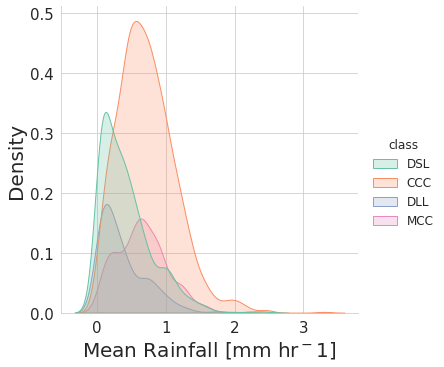

In [66]:
pal = "Set2"
penguins = pd.DataFrame(rain.drop(columns='geometry')).reset_index(drop=True)

with sns.plotting_context({"legend.fontsize": "large", "legend.title_fontsize": "large"}):
    sns.displot(penguins, x="mean_precip", hue="class", kind="kde",fill=True,palette=pal)

ax = plt.gca()
#ax = fg.axes[0,0].get_legend()
#plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend titleax.set_xlabel("Mean rainfall [mm hr$^-1$]", fontsize = 20)
ax.set_ylabel("Density", fontsize = 20)
ax.set_xlabel("Mean Rainfall [mm hr$^-1$]", fontsize = 20)
ax.tick_params(labelsize=15)

## Number of MCSs by Class 

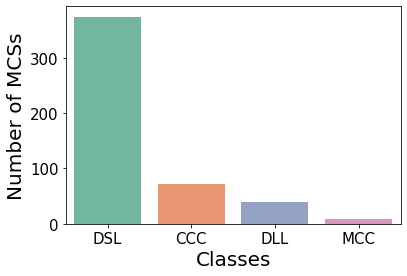

In [7]:
pal = "Set2"
ax = sns.countplot(x="class", data=c, palette=pal)
ax.set_xlabel("Classes", fontsize = 20)
ax.set_ylabel("Number of MCSs", fontsize = 20)
ax.tick_params(labelsize=15)

## MCSs Area Distribution

Text(0, 0.5, 'MCSs Area [km$^2$]')

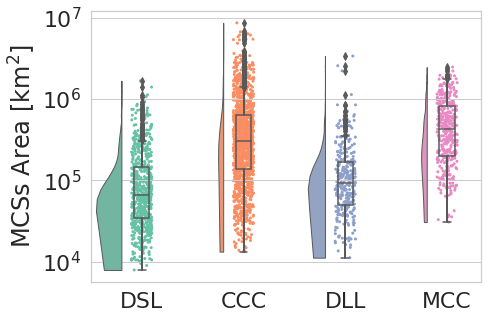

In [8]:
dx = list(cs["class"]); dy = list(cs["area_km2"]); ort = "v"; pal = "Set2";
sns.set(style="whitegrid",font_scale=2)
f, ax = plt.subplots(figsize=(7, 5))
pt.RainCloud(x=dx,y=dy,data=cs, palette = pal, width_viol = .5, ax = ax, orient = ort)
plt.yscale("log")
plt.ylabel('MCSs Area [km$^2$]')

In [57]:
#cs.area_km2.hist(bins=30); plt.gca().set_xscale("log")

## MCSs Duration Distribtuion

### Define a variable that computes the duration for each MCS (because it is CE data and hourly outputs unique works)

In [9]:
durations = cs.groupby("id").apply(lambda g: g.time.unique().size)
durations.name = "duration"
#durations.plot.hist()

# Make use of the variable c which groups by class to be able to plot by class
c["duration"] = durations

### Split c by organized and disorganized classes

In [10]:
c2 = c[c["class"].isin(["MCC", "CCC"])]
c3 = c[c["class"].isin(["DLL", "DSL"])]

Text(0.5, 0, 'MCSs Duration [hr]')

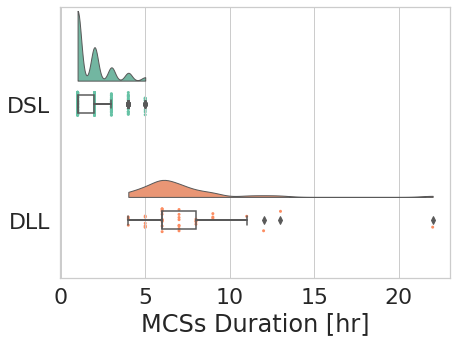

In [13]:
dx = list(c3["class"]); dy = list(c3["duration"]); ort = "h"; pal = "Set2";
sns.set(style="whitegrid",font_scale=2)
f, ax = plt.subplots(figsize=(7,5))
pt.RainCloud(x=dx,y=dy,data=c3, palette = pal, width_viol = 1.2, ax = ax, orient = ort)
#plt.xscale("log")
plt.xlabel('MCSs Duration [hr]')

Text(0.5, 0, 'MCSs Duration [hr]')

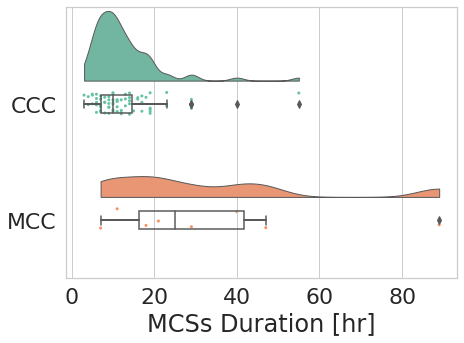

In [41]:
dx = list(c2["class"]); dy = list(c2["duration"]); ort = "h"; pal = "Set2";
sns.set(style="whitegrid",font_scale=2)
f, ax = plt.subplots(figsize=(7,5))
pt.RainCloud(x=dx,y=dy,data=c2, palette = pal, width_viol = 1.2, ax = ax, orient = ort)
#plt.xscale("log")
plt.xlabel('MCSs Duration [hr]')

## Genesis/Lysis Location by Class

### Add to c genesis/termination points by id so it they can be plotted by class

In [18]:
c2["lon_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.x)
c2["lon_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.x)
c2["lat_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.y)
c2["lat_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.y)

c3["lon_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.x)
c3["lon_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.x)
c3["lat_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.y)
c3["lat_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.y)


/glade/scratch/knocasio/ipykernel_118167/190423089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2["lon_end"] = cs.groupby("id").apply(lambda g: g.iloc[-1].geometry.centroid.x)
/glade/scratch/knocasio/ipykernel_118167/190423089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2["lon_in"] = cs.groupby("id").apply(lambda g: g.iloc[0].geometry.centroid.x)
/glade/scratch/knocasio/ipykernel_118167/190423089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [16]:
cs

,geometry,area_km2,area219_km2,time,itime,duration,id,class
10,"POLYGON ((166.75000 6.73783, 169.25000 7.58141...",1.633659e+05,119486.430461,2006-09-08 14:00:00,0,0 days 01:00:00,0,DSL
21,"POLYGON ((166.75000 27.70158, 167.00000 27.767...",1.711903e+04,5579.372522,2006-09-08 14:00:00,0,0 days 01:00:00,1,DSL
23,"POLYGON ((164.00000 30.89926, 166.00000 32.940...",1.208633e+05,12406.045230,2006-09-08 14:00:00,0,0 days 01:00:00,2,DSL
3,"POLYGON ((156.25000 -0.31079, 157.00000 0.0812...",1.954487e+04,11009.523649,2006-09-08 14:00:00,0,0 days 01:00:00,3,DSL
9,"POLYGON ((155.50000 6.46732, 156.29934 8.12500...",4.361601e+05,299378.907537,2006-09-08 14:00:00,0,0 days 01:00:00,4,DSL
...,...,...,...,...,...,...,...,...
10,"POLYGON ((93.75000 -0.27679, 95.50000 -0.19343...",1.840895e+05,51230.995770,2006-09-13 18:00:00,115,0 days 01:00:00,464,CCC
18,"POLYGON ((96.00000 17.66851, 97.00000 18.08830...",4.371303e+05,177435.774722,2006-09-13 18:00:00,115,0 days 01:00:00,471,CCC
1,"POLYGON ((88.75000 -0.76241, 89.00000 -0.69936...",2.361151e+06,784764.046105,2006-09-13 18:00:00,115,0 days 01:00:00,464,CCC
19,"POLYGON ((89.25000 23.32847, 90.00000 23.37754...",4.435268e+04,18672.884749,2006-09-13 18:00:00,115,0 days 01:00:00,487,DSL


## Genesis/Lysis of Organized MCSs

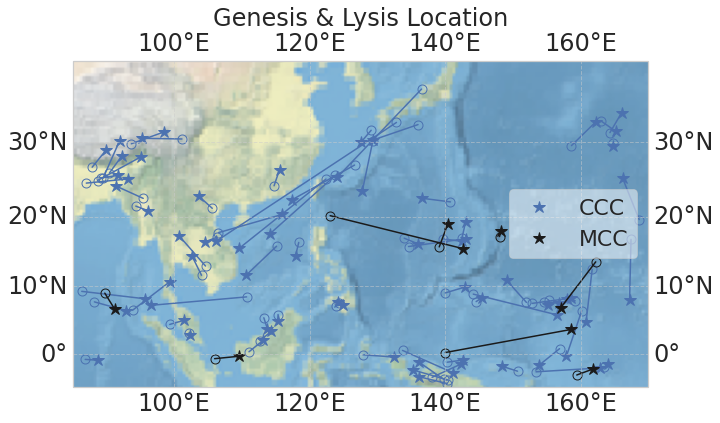

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

lon_min = tb.lon.min()
lon_max = tb.lon.max()
lat_min = tb.lat.min()
lat_max = tb.lat.max()

fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection=ccrs.Mercator())
ax.stock_img()   

#colors = {"CCC": "b", "DSL": "r", "MCC": "k", "DLL": "purple"}

#colors = {"DSL": "r", "DLL": "purple"}
colors = {"CCC": "b",  "MCC": "k"}
for class_, g in c2.groupby("class"):
    color = colors[class_]
    ax.plot(g.lon_in, g.lat_in, "*", transform=ccrs.PlateCarree(), markersize=12, label=class_, c=color)
    ax.plot([g.lon_in,g.lon_end], [g.lat_in,g.lat_end], "-", transform=ccrs.PlateCarree(), markersize=12, c=color)
    ax.plot(g.lon_end, g.lat_end, "o", transform=ccrs.PlateCarree(), markersize=9, mfc="none", c=color)

gridlines = ax.gridlines(draw_labels=True,alpha=0.5, linestyle='--')

plt.title('Genesis & Lysis Location')
plt.legend(framealpha=0.5)

extent = [lon_min, lon_max, lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())

## Genesis/Lysis of Disorganized MCSs

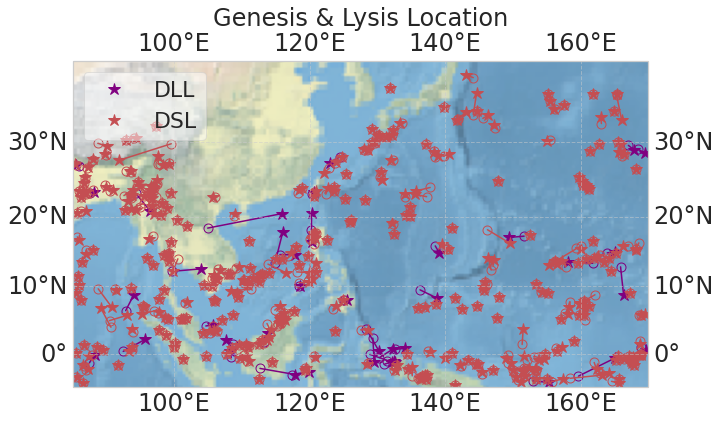

In [19]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection=ccrs.Mercator())
ax.stock_img()   

#colors = {"CCC": "b", "DSL": "r", "MCC": "k", "DLL": "purple"}

colors = {"DSL": "r", "DLL": "purple"}
#colors = {"CCC": "b",  "MCC": "k"}
for class_, g in c3.groupby("class"):
    color = colors[class_]
    ax.plot(g.lon_in, g.lat_in, "*", transform=ccrs.PlateCarree(), markersize=12, label=class_, c=color)
    ax.plot([g.lon_in,g.lon_end], [g.lat_in,g.lat_end], "-", transform=ccrs.PlateCarree(), markersize=12, c=color)
    ax.plot(g.lon_end, g.lat_end, "o", transform=ccrs.PlateCarree(), markersize=9, mfc="none", c=color)

gridlines = ax.gridlines(draw_labels=True,alpha=0.5, linestyle='--')

plt.title('Genesis & Lysis Location')
plt.legend(framealpha=0.5)

extent = [lon_min, lon_max, lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [ ]:
b